In [1]:
library(tidyverse)
library(progress)
library(nout)

source("../R/utils_data.R")
source("../R/utils_experiments.R")
source("../R/utils_g.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Demo

## Generate scores and plot them

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


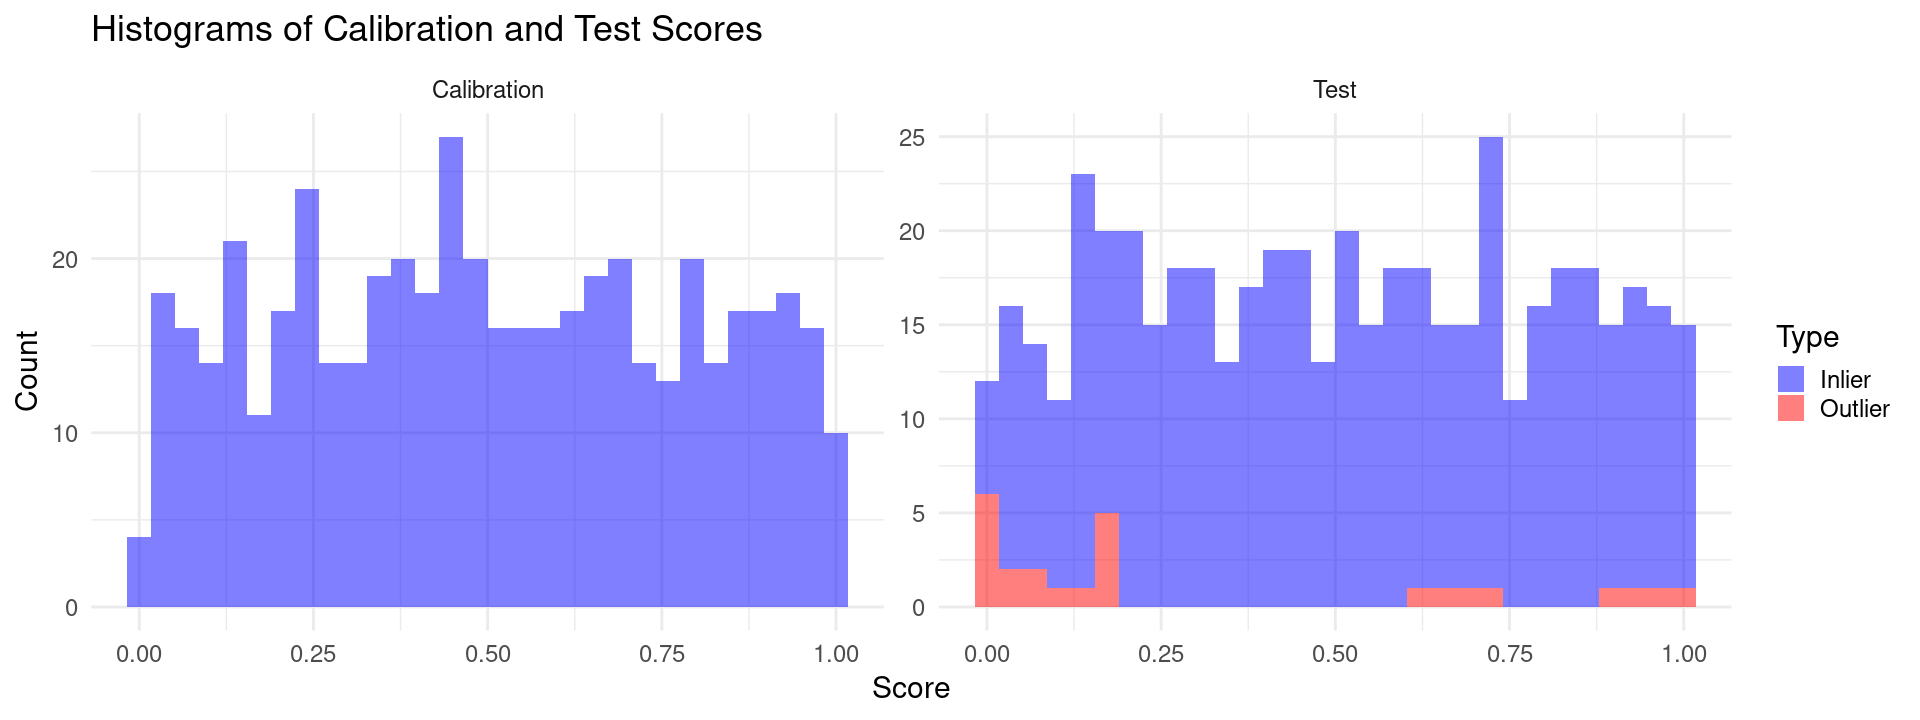

In [2]:
#set.seed(123) # For reproducibility

# Choose alternative distribution
#alternative <- "uniform"     #
#alternative <- "lehmann_k3"  #
alternative <- "beta_0.25_0.25"     #
#alternative <- "beta_4_4"     #
#alternative <- "normal_-0.5_0.2"
#alternative <- "normal_0_2"

# Generate a calibration set of inliers from a uniform distribution 
# and a test set containing a mixture of inliers and outliers from a different distribution.
data <- generate_cal_test_scores(n_cal = 500, n_test = 500, prop_out = 0.05, alternative = alternative)

# Prepare the data for plotting with an additional column for inliers/outliers
calibration_df <- tibble(score = data$scores.cal, set = "Calibration", type = "Inlier")
test_df <- tibble(score = data$scores.test, set = "Test", type = ifelse(data$outlier.test == 1, "Outlier", "Inlier"))
plot_data <- bind_rows(calibration_df, test_df)

# Adjust plot size
options(repr.plot.width = 16, repr.plot.height = 6)

# Create side-by-side histograms
ggplot(plot_data, aes(x = score, fill = type)) +
  geom_histogram(alpha = 0.5) +
  facet_wrap(. ~ set, scales = "free_y") +
  theme_minimal(base_size = 18) +  # Increase base font size
  labs(title = "Histograms of Calibration and Test Scores",
       x = "Score",
       y = "Count",
       fill = "Type") +
  scale_fill_manual(values = c("Inlier" = "blue", "Outlier" = "red"))

## Plot the oracle density g

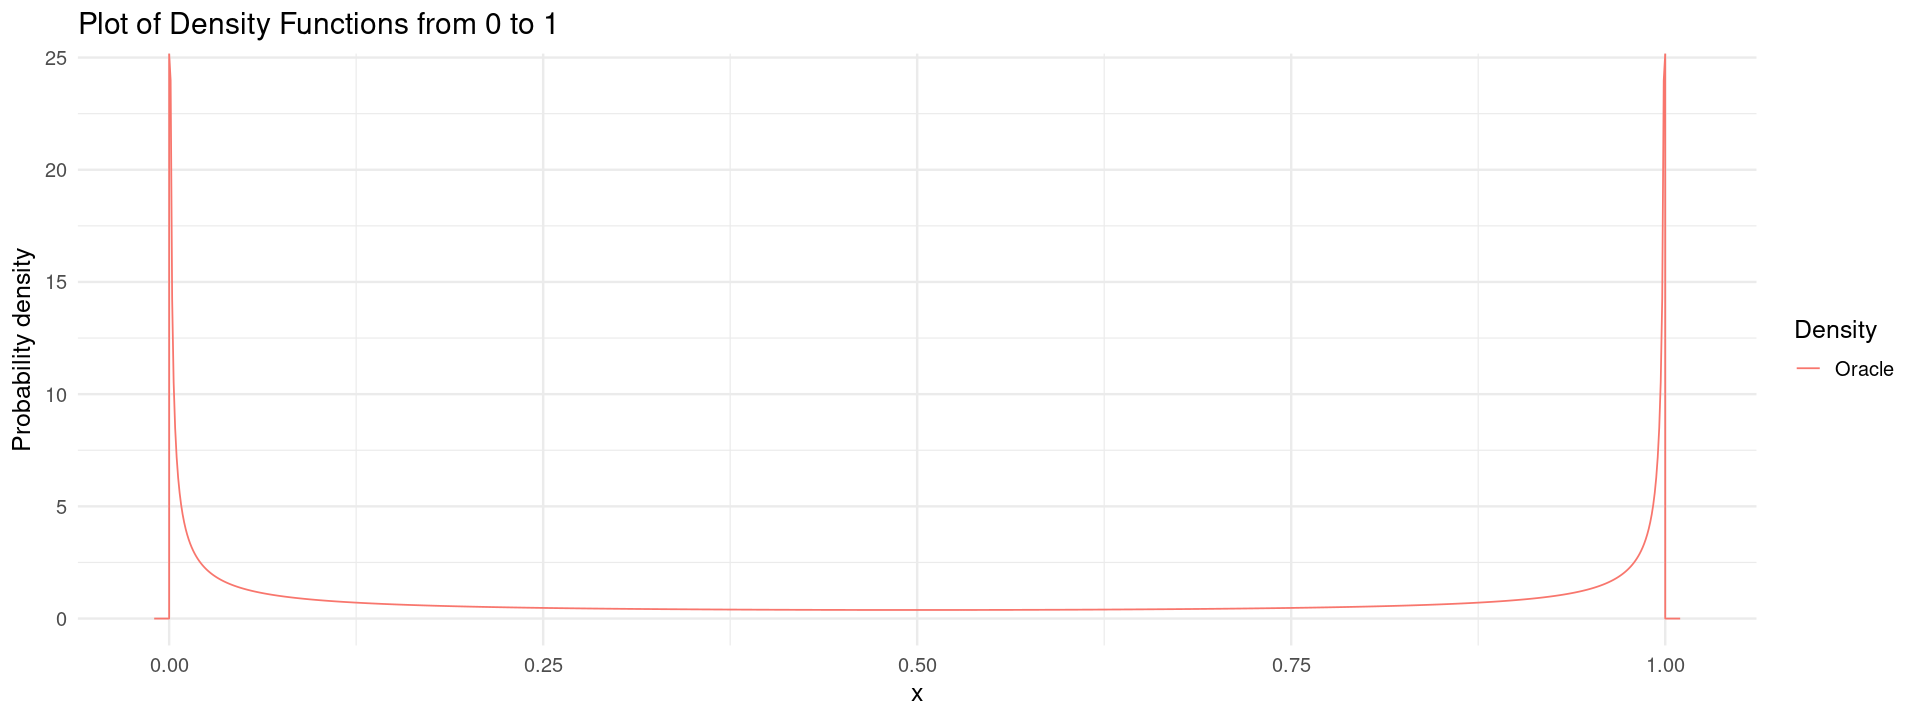

In [3]:
plot_density <- function(function_list) {
  # Generate a sequence of values between 0 and 1
  x_values <- seq(0, 1, length.out = 1000)
  
  # Create an empty list to store plot data
  plot_data_list <- list()
  
  # Loop through each function in the list
  for (function_name in names(function_list)) {
    my_function <- function_list[[function_name]]
    
    # Evaluate the function at these points
    y_values <- sapply(x_values, my_function)
    
    # Add padding values
    x_values_padded <- c(-1e-2, -1e-6, x_values, 1 + 1e-6, 1 + 1e-2)
    y_values_padded <- c(0, 0, y_values, 0, 0)
    
    # Create a data frame for the current function
    plot_data <- data.frame(x = x_values_padded, y = y_values_padded, function_name = function_name)
    
    # Add to the list
    plot_data_list[[function_name]] <- plot_data
  }
  
  # Combine all data frames into one
  combined_plot_data <- do.call(rbind, plot_data_list)
  
  # Plot the functions with different colors
  ggplot(combined_plot_data, aes(x = x, y = y, color = function_name)) +
    geom_line() +
    ylim(0, NA) +
    theme_minimal(base_size = 15) +
    labs(title = "Plot of Density Functions from 0 to 1",
         x = "x",
         y = "Probability density") +
    scale_color_discrete(name = "Density")
}

density_oracle <- function(x) density_scores(x, alternative)
plot_density(c(Oracle=density_oracle))

## Estimate the density g

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


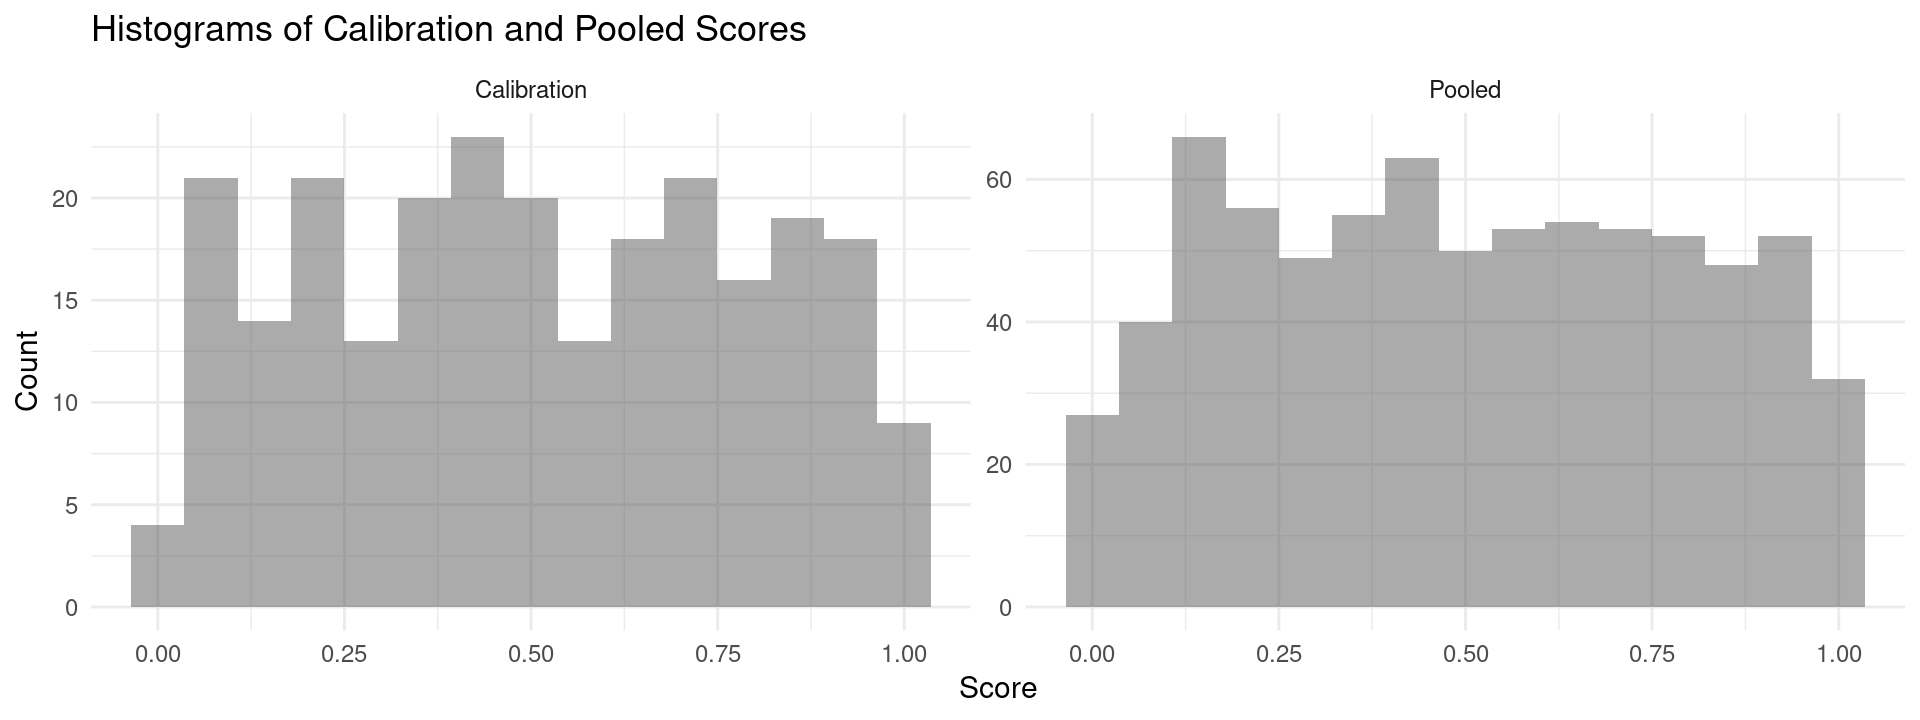

In [4]:
source("../R/utils_g.R")

S_X = data$scores.cal
S_Y = data$scores.test
prop_cal = 0.5

m = length(S_X)
n = length(S_Y)
m_2 = pmin(n, as.integer(round(prop_cal * m)))
m_1 = m - m_2

idx_X_1 = sample(m, m_1)
idx_X_2 = setdiff(1:m, idx_X_1)
S_X1 = S_X[idx_X_1]
S_X2 = S_X[idx_X_2]

S_pooled = sample(c(S_X2, S_Y))

tmp_df.1 <- tibble(score = S_X1, set = "Calibration")
tmp_df.2 <- tibble(score = S_pooled, set = "Pooled")
tmp_df <- rbind(tmp_df.1, tmp_df.2)

ggplot(tmp_df, aes(x = score)) +
  geom_histogram(alpha = 0.5, bins=15) + 
    facet_wrap(. ~ set, scales = "free_y") +
  theme_minimal(base_size = 18) +  # Increase base font size
  labs(title = "Histograms of Calibration and Pooled Scores",
       x = "Score",
       y = "Count",
       fill = "Type") +
  scale_fill_manual(values = c("Inlier" = "blue", "Outlier" = "red"))

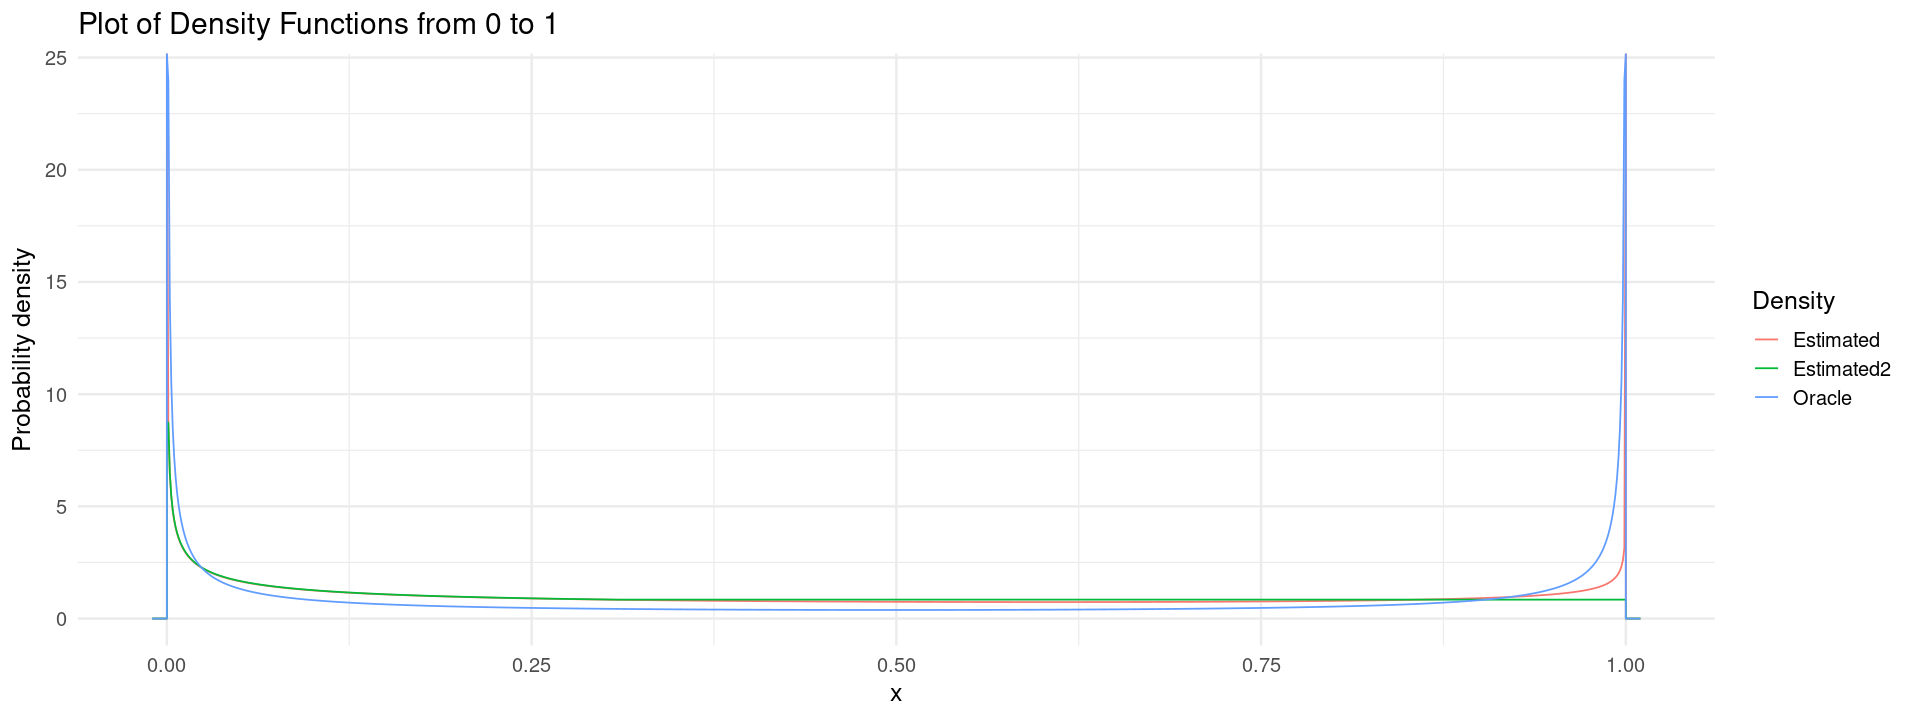

In [7]:
source("../R/utils_g.R")
g.hat.1 <- estimate_g(S_X1, S_pooled, method="betamix")$pdf
g.hat.2 <- estimate_g(S_X1, S_pooled, method="betamix", monotone=TRUE)$pdf

plot_density(c(Oracle=density_oracle, Estimated=g.hat.1, Estimated2=g.hat.2))

## Apply different global tests

In [8]:
source("../R/utils_experiments.R")

run_global_testing(data, alternative=alternative)

Method,p.value
<chr>,<dbl>
Fisher,0.38752213
WMW,0.54767201
WMW_k2,0.42587684
WMW_k3,0.36769534
Shirashi_oracle,0.06574413
Shirashi_ghat_betamix,0.10827028
Shirashi_ghat_betamix_inc,0.11115239


# Run repeated experiments

In [24]:
source("../R/utils_g.R")

# Define function to run a single experiment
run_experiment <- function(seed, prop_out, alternative) {
    set.seed(seed) # For reproducibility
    # Generate data
    data <- generate_cal_test_scores(n_cal = 500, n_test = 500, prop_out = prop_out, alternative = alternative)
    # Apply different methods for global testing
    res <- run_global_testing(data, alternative=alternative)
    # Store results
    results <- tibble(Seed = seed, Prop_Out = prop_out) %>% cbind(res)
    return(results)
}

In [10]:
# Define function to run multiple experiments and assemble results
run_multiple_experiments <- function(n_exp, prop_out_values, alternative) {
    results_list <- list()
    
    # Print progress bar header
    cat("Running experiments\n")
    pb <- txtProgressBar(min = 0, max = length(prop_out_values) * n_exp, style = 3)
    
    counter <- 1
    for (prop_out in prop_out_values) {
        for (i in 1:n_exp) {
            results_list[[counter]] <- run_experiment(i, prop_out, alternative)
            setTxtProgressBar(pb, counter)
            counter <- counter + 1
        }
    }
    
    close(pb)
    
    results_df <- bind_rows(results_list)
    return(results_df)
}

In [14]:
# Choose alternative distribution
#alternative <- "uniform"     #
#alternative <- "lehmann_k2"  #
alternative <- "beta_0.25_0.25"     #
#alternative <- "normal_1_0.2"

# List of values for proportion of outliers
prop_out_values <- c(0.05)

# Number of repetitions for each experiment
n_exp <- 100

# Run the experiments
results <- run_multiple_experiments(n_exp, prop_out_values, alternative)

Running experiments
  |==================================                                    |  48%

ERROR: Error in integrate(pdf_func, lower_bound, x_grid[i]): the integral is probably divergent


`summarise()` has grouped output by 'Method'. You can override using the
`.groups` argument.
Warning message:
“The shape palette can deal with a maximum of 6 discrete values because more
than 6 becomes difficult to discriminate
ℹ you have requested 7 values. Consider specifying shapes manually if you need
  that many have them.”
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


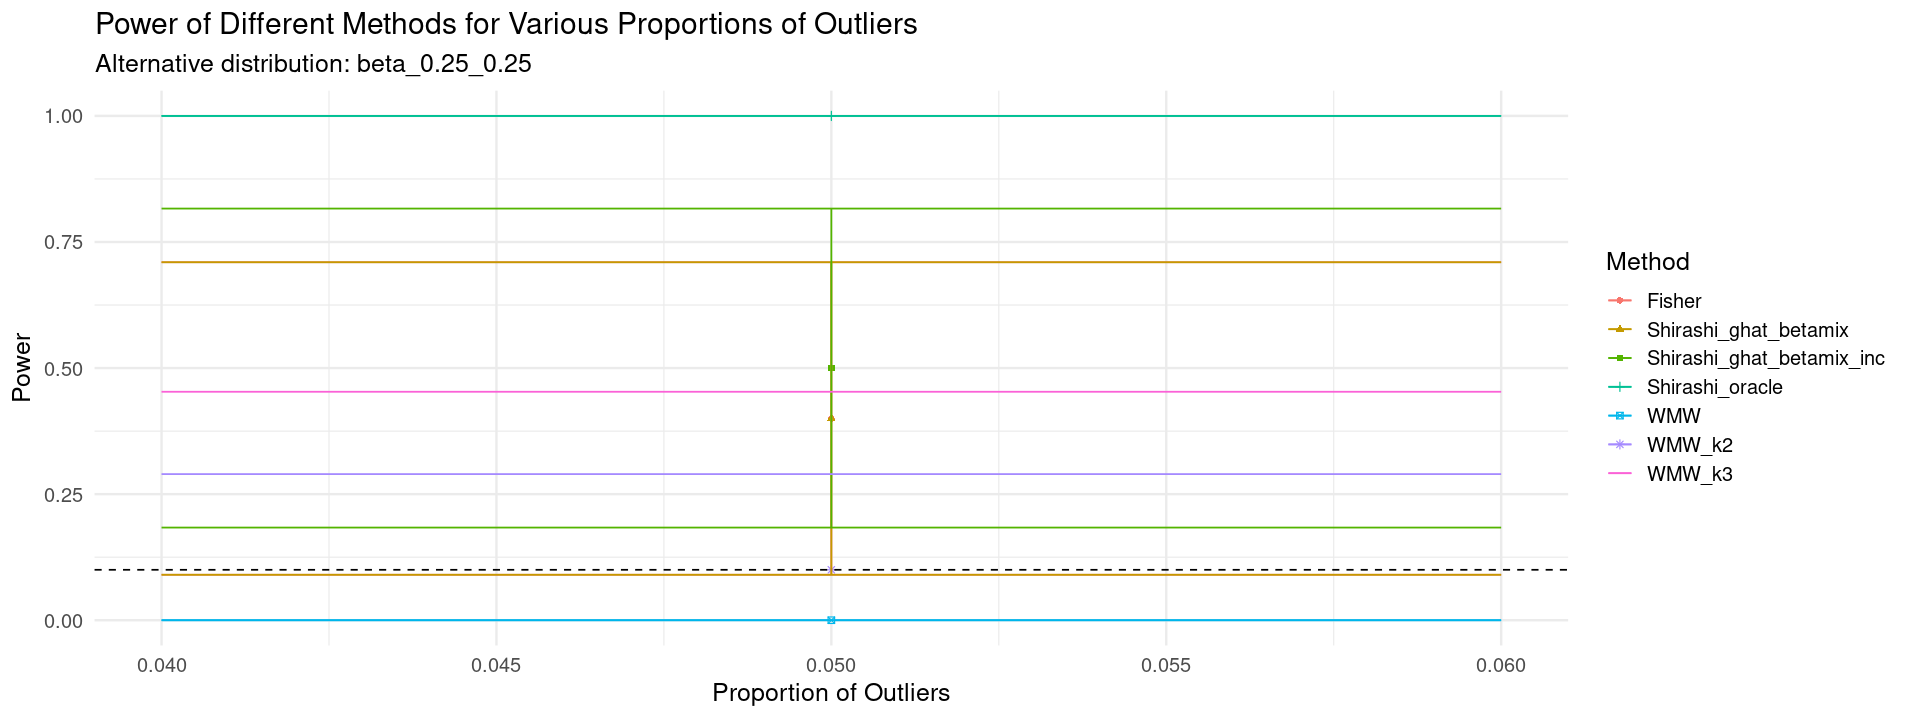

In [13]:
# Significance level
alpha <- 0.1

# Calculate power for different methods and prop_out values
power_results <- results %>%
  group_by(Method, Prop_Out) %>%
  summarize(
    Power = mean(p.value < alpha),
    SE = sqrt((Power * (1 - Power)) / n())
  )

# Plot the power for different methods and prop_out values
power_results |>
  #filter(! Method %in% c("WMW","WMW_k2")) |>
  ggplot(aes(x = Prop_Out, y = Power, color = Method, shape=Method)) +
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin = Power - 2*SE, ymax = Power + 2*SE), width = 0.02) +
  geom_hline(yintercept=alpha, linetype=2) +
  theme_minimal(base_size = 15) +
  labs(title = "Power of Different Methods for Various Proportions of Outliers",
       subtitle = sprintf("Alternative distribution: %s", alternative),
       x = "Proportion of Outliers",
       y = "Power",
       color = "Method") +
  ylim(0, 1)

In [ ]:
power_results